
<hr>

## Our Idea

This notebook uses a similar idea but takes two images as input: A content-image and a style-image. We then wish to create a mixed-image which has the contours of the content-image and the colours and texture of the style-image.


# What is this process?

- we want countour lines from content image
- we want and textures from style image
- normally used to identify if features exist for classification
- i.e minimize loss between labeled image and feature map output
- each filter performs operation on input
- outputs 3D feature map/activation map. 
- start with random noise for mixed image
- calculate different loss functions at different layers
- weigh these loss functions respectively
- gradient of combined loss functions to update mixed image
- we do this 100-1000 times until image is mixed


content loss
--------
- calculate features/values at higher layer 
- minimize difference between activation features between content and  -- mixed image. calculate mean squared error. that is loss function. we want to minimize this.

- we cache the feature from content image because we don't need to recalculate that. 

style loss
--------
- multiple layers 
- minimize difference between gram matrix for layer 1 and 2 for style and mixed image



## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

In [396]:
tf.__version__

'1.13.1'

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

### Import for Mask R-CNN

In [0]:
# import the necessary packages
import numpy as np
import argparse
import random
import time
import cv2
import os

### Argument parse

In [0]:
# location of mask_rcnn
mask_rcnn_path = "mask-rcnn/mask-rcnn-coco"

# location of image
image_location = "images/pranshu.jpg"

# input image
# content_image

#  Load the COCO class labels our Mask R-CNN was trained on

In [399]:
!pwd
labelsPath = os.path.sep.join([mask_rcnn_path,
	"object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")


/content


# Load the set of colors that will be used when visualizing a given
# Instance segmentation

In [0]:
colorsPath = os.path.sep.join([mask_rcnn_path, "colors.txt"])
COLORS = open(colorsPath).read().strip().split("\n")
COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
COLORS = np.array(COLORS, dtype="uint8")

# Derive the paths to the Mask R-CNN weights and model configuration


In [0]:
weightsPath = os.path.sep.join([mask_rcnn_path,
	"frozen_inference_graph.pb"])

configPath = os.path.sep.join([mask_rcnn_path,
	"mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

# Load our Mask R-CNN trained on the COCO dataset (90 classes) from disk



```
sudo pip3 install opencv-contrib-python
```



In [402]:
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] loading Mask R-CNN from disk...


# Load our input image and grab its spatial dimensions

In [0]:
image = cv2.imread(image_location)
(H, W) = image.shape[:2]

## VGG-16 Model

In [0]:
import vgg16

The VGG-16 model is downloaded from the internet. This is the default directory where you want to save the data-files. The directory will be created if it does not exist.

In [0]:
# vgg16.data_dir = 'vgg16/'

Download the data for the VGG-16 model if it doesn't already exist in the directory.

In [406]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


## Helper-functions for image manipulation

This function loads an image and returns it as a numpy array of floating-points. The image can be automatically resized so the largest of the height or width equals `max_size`.

In [0]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

Save an image as a jpeg-file. The image is given as a numpy array with pixel-values between 0 and 255.

In [0]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

This function plots a large image. The image is given as a numpy array with pixel-values between 0 and 255.

In [0]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

This function plots the content-, mixed- and style-images.

In [0]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Loss Functions

These helper-functions create the loss-functions that are used in optimization with TensorFlow.

This function creates a TensorFlow operation for calculating the Mean Squared Error between the two input tensors.

In [0]:
#average of the squre of the errors. 
#between output values for both images at a given layer
#The smaller the means squared error, the closer you are to finding the line of best fit. 
# square the difference between both output feature map/activation map
# and average all those values by adding all then dividing by n 
# https://www.tensorflow.org/api_docs/python/tf/reduce_mean
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

This function creates the loss-function for the content-image. It is the Mean Squared Error of the feature activations in the given layers in the model, between the content-image and the mixed-image. When this content-loss is minimized, it therefore means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers you select, this should transfer the contours from the content-image to the mixed-image.

In [0]:
#step 3 - content image is 3d numpy array, indices for the layers
#we want to use for content loss
#you should expirment what looks good for different layers
#there is not one best layer, we haven't found a way to minimize
#loss for beauty. how to quantify?
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    #A python dictionary object is generated with the 
    # placeholders as keys and the representative feed 
    #tensors as values.
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    # collection of filters
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        #because we are calculating losses per layer
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

We will do something similar for the style-layers, but now we want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

One way of doing this, is to calculate the so-called Gram-matrix for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

This is the helper-function for calculating the Gram-matrix of a tensor output by a convolutional layer in the neural network. The actual loss-function is created further below.

In [0]:
#The Gram matrix, defined as https://i.stack.imgur.com/tU9ow.png 
#is used to 
#measure the correlation between channels after flattening the 
#filter images into vectors

#Gatys when asked why gram matrix at a talk was that the 
#Gram matrix encodes second 
#order statistics of the set of filters.
#it sort of mushes up all the features at a given layer, 
#tossing spatial information in favor of a measure of 
#how the different features are correlated 

def gram_matrix(tensor):
    #gram matrix is vector of dot products for vectors
    #of the feature activations of a style layer
    
    #4d tensor from convolutional layer
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    #-1 means whatever number makes the data fit 
    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    
    #gram matrix is transpose matrix with itself
    #so each entry in gram matrix
    #tells us if a feature channel has a tendency
    #to be activated with another feature channel
    
    #idea is to make the mixed image match patterns from style image
    
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram                            

The next function creates the loss-function for the style-image. It is quite similar to `create_content_loss()` above, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.

In [0]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            
            
            #between gram matrix and value of gram matrix when inputting 
            #style image
            
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

This creates the loss-function for denoising the mixed-image. The algorithm is called [Total Variation Denoising](https://en.wikipedia.org/wiki/Total_variation_denoising) and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image. This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

In [0]:
#shifts input image by 1 pixel on x and y axis 
#calculate difference between shifted and original image
#absolute value to make positive
#calculate sum of pixels in those images
#helps suppress noise in mixed image we are generating



def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## Style-Transfer Algorithm

This is the main optimization algorithm for the Style-Transfer algorithm. It is basically just gradient descent on the loss-functions defined above.

This algorithm also uses normalization of the loss-functions. This appears to be a novel idea not previously published. In each iteration of the optimization, the loss-values are adjusted so each of them equals one. This allows the user to set the loss-weights independently of the chosen style- and content-layers. It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.

In [0]:
#relative weights - normalized.
#style should have more weight than content
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    
    #adjust levels of loss functions, normalize them
    #multiply them with a variable
    #taking reciprocal values of loss values of content, style, denoising
    #small constant to avoid divide by 0
    #adjustment value normalizes loss so approximately 1
    #weights should be set relative to each other dont depend on layers
    #we are using
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image. (mixed)
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    #where we first init it
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        #Remove single-dimensional entries from the shape of an array.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        #Ratio of weights:updates
        #akin to learning rate
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        #gradient descent
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        #Given an interval, values outside the interval are clipped 
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

## Load Images

First we load the content-image which has the overall contours that we want in the mixed-image.

In [0]:
content_filename = 'images/pranav2.jpg'
content_image = load_image(content_filename, max_size=None)

Then we load the style-image which has the colours and textures we want in the mixed-image.

In [0]:
style_filename = 'images/style8.jpg'
style_image = load_image(style_filename, max_size=300)

Then we define a list of integers which identify the layers in the neural network that we want to use for matching the content-image. These are indices into the layers in the neural network. For the VGG16 model, the 5th layer (index 4) seems to work well as the sole content-layer.

In [0]:
content_layer_ids = [4]

Then we define another list of integers for the style-layers.

In [0]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]


# Construct a blob from the input image and then perform a forward pass of the Mask R-CNN, giving us 
# (1) the bounding box  coordinates of the objects in the image along with 
# (2) the pixel-wise segmentation for each specific object

In [421]:
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()

# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 4.671838 seconds
[INFO] boxes shape: (1, 1, 3, 7)
[INFO] masks shape: (100, 90, 15, 15)


# Loop over the number of detected objects


In [0]:
visualize = 1
confidence_user = 0.7
threshold = 0.3
threshold = 0.3  


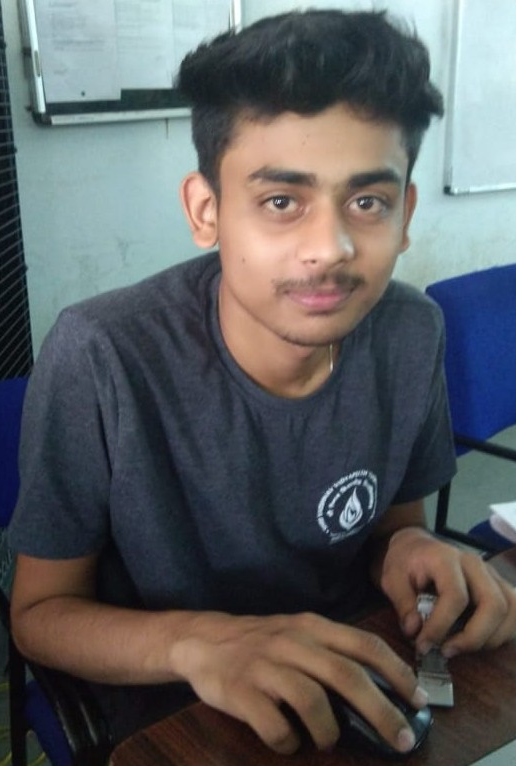

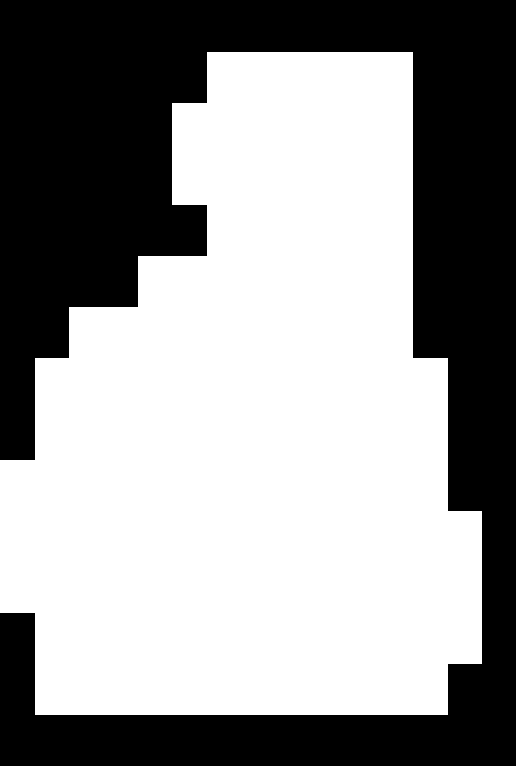

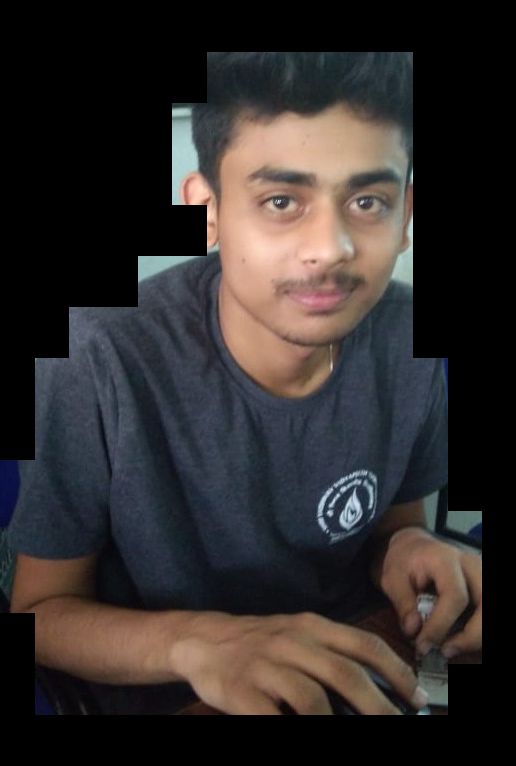

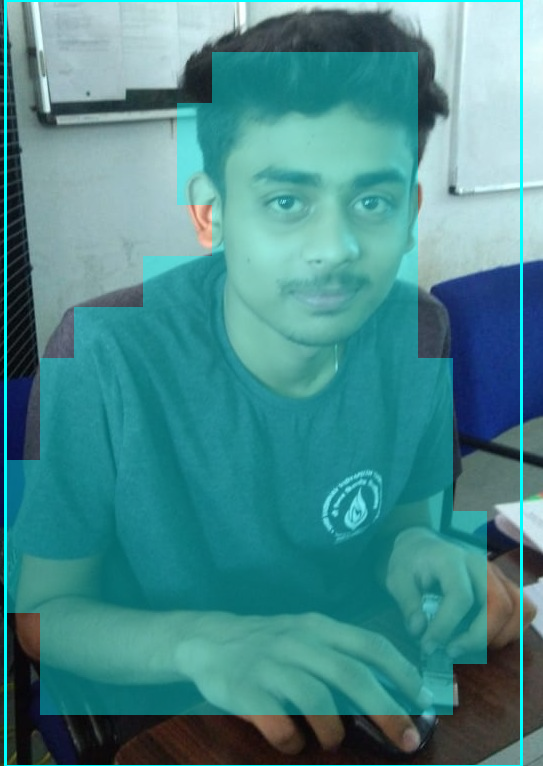

In [423]:
from google.colab.patches import cv2_imshow
content_image_2 = np.zeros((image.shape[0],image.shape[1]))
visMask = np.zeros((image.shape[0],image.shape[1]))
# vis_image_1 = np.zeros((image.shape[0],image.shape[1]))

import cv2

for i in range(0, boxes.shape[2]):
	# extract the class ID of the detection along with the confidence
	# (i.e., probability) associated with the prediction
	classID = int(boxes[0, 0, i, 1])
	confidence = boxes[0, 0, i, 2]

	# filter out weak predictions by ensuring the detected probability
	# is greater than the minimum probability
	if confidence > confidence_user:
		# clone our original image so we can draw on it
		clone = image.copy()

		# scale the bounding box coordinates back relative to the
		# size of the image and then compute the width and the height
		# of the bounding box
		box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
		(startX, startY, endX, endY) = box.astype("int")
		boxW = endX - startX
		boxH = endY - startY

		# extract the pixel-wise segmentation for the object, resize
		# the mask such that it's the same dimensions of the bounding
		# box, and then finally threshold to create a *binary* mask
		mask = masks[i, classID]
		mask = cv2.resize(mask, (boxW, boxH),
			interpolation=cv2.INTER_NEAREST)
		mask = (mask > threshold)

		# extract the ROI of the image
		roi = clone[startY:endY, startX:endX]

		# check to see if are going to visualize how to extract the
		# masked region itself
		if visualize > 0:
			# convert the mask from a boolean to an integer mask with
			# to values: 0 or 255, then apply the mask
			visMask = (mask * 255).astype("uint8")
			instance = cv2.bitwise_and(roi, roi, mask=visMask)

			# show the extracted ROI, the mask, along with the
			# segmented instance
			cv2_imshow(roi)
			cv2_imshow(visMask)
			cv2_imshow(instance)
      #Copy the extracted image
			content_image_2 = instance

		# now, extract *only* the masked region of the ROI by passing
		# in the boolean mask array as our slice condition
		roi = roi[mask]

		# randomly select a color that will be used to visualize this
		# particular instance segmentation then create a transparent
		# overlay by blending the randomly selected color with the ROI
		color = random.choice(COLORS)
		blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

		# store the blended ROI in the original image
		clone[startY:endY, startX:endX][mask] = blended

		# draw the bounding box of the instance on the image
		color = [int(c) for c in color]
		cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)

		# draw the predicted label and associated probability of the
		# instance segmentation on the image
		text = "{}: {:.4f}".format(LABELS[classID], confidence)
		cv2.putText(clone, text, (startX, startY - 5),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

		# show the output image
		cv2_imshow(clone)
		cv2.waitKey(0)
    
	

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 1.79e-10, Style: 1.39e-29, Denoise: 1.27e-06


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 1.78e-10, Style: 2.52e-28, Denoise: 5.69e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.65e-10, Style: 6.84e-28, Denoise: 5.22e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.57e-10, Style: 2.19e-27, Denoise: 4.60e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.78e-10, Style: 5.40e-28, Denoise: 5.09e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.66e-10, Style: 2.08e-27, Denoise: 4.39e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 1.88e-10, Style: 4.28e-28, Denoise: 5.20e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 1.75e-10, Style: 8.45e-28, Denoise: 4.39e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 1.86e-10, Style: 6.72e-28, Denoise: 4.30e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 1.89e-10, Style: 5.94e-28, Denoise: 4.24e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 100
Weight Adj. for Content: 1.74e-10, Style: 1.81e-27, Denoise: 4.05e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 110
Weight Adj. for Content: 9.82e-11, Style: 7.42e-29, Denoise: 3.00e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 1.17e-10, Style: 8.81e-29, Denoise: 2.97e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 130
Weight Adj. for Content: 1.26e-10, Style: 3.41e-28, Denoise: 3.81e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 140
Weight Adj. for Content: 1.24e-10, Style: 3.46e-28, Denoise: 3.54e-08


<IPython.core.display.Javascript object>

. . . . . . . . . 
Iteration: 149
Weight Adj. for Content: 1.90e-10, Style: 8.15e-28, Denoise: 4.48e-08


<IPython.core.display.Javascript object>


Final image:


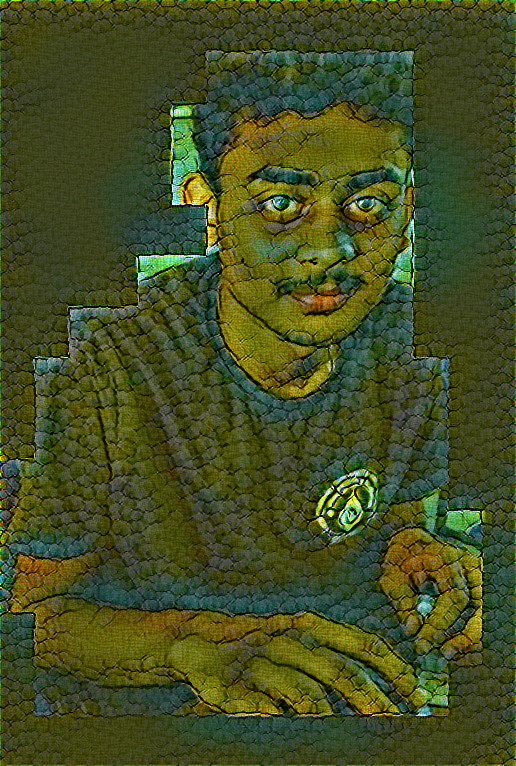

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 1.64e-10, Style: 9.71e-30, Denoise: 1.20e-06


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 9.65e-11, Style: 6.32e-29, Denoise: 3.10e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 8.54e-11, Style: 9.15e-29, Denoise: 2.72e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 9.22e-11, Style: 1.56e-28, Denoise: 2.75e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 9.55e-11, Style: 1.96e-28, Denoise: 2.71e-08


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 9.71e-11, Style: 2.09e-28, Denoise: 2.65e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 9.78e-11, Style: 2.05e-28, Denoise: 2.59e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 9.83e-11, Style: 1.98e-28, Denoise: 2.53e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 9.85e-11, Style: 1.88e-28, Denoise: 2.48e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 9.89e-11, Style: 1.80e-28, Denoise: 2.44e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 100
Weight Adj. for Content: 9.94e-11, Style: 1.77e-28, Denoise: 2.41e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 110
Weight Adj. for Content: 9.98e-11, Style: 1.73e-28, Denoise: 2.38e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 1.00e-10, Style: 1.69e-28, Denoise: 2.35e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 130
Weight Adj. for Content: 1.01e-10, Style: 1.66e-28, Denoise: 2.33e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 140
Weight Adj. for Content: 1.01e-10, Style: 1.66e-28, Denoise: 2.31e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 150
Weight Adj. for Content: 1.02e-10, Style: 1.66e-28, Denoise: 2.30e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 160
Weight Adj. for Content: 1.02e-10, Style: 1.64e-28, Denoise: 2.28e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 170
Weight Adj. for Content: 1.02e-10, Style: 1.63e-28, Denoise: 2.27e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 180
Weight Adj. for Content: 1.03e-10, Style: 1.63e-28, Denoise: 2.26e-08


<IPython.core.display.Javascript object>

. . . . . . . . . . 
Iteration: 190
Weight Adj. for Content: 1.03e-10, Style: 1.64e-28, Denoise: 2.24e-08


<IPython.core.display.Javascript object>

. . . . . . . . . 
Iteration: 199
Weight Adj. for Content: 1.47e-10, Style: 2.32e-28, Denoise: 2.77e-08


<IPython.core.display.Javascript object>


Final image:


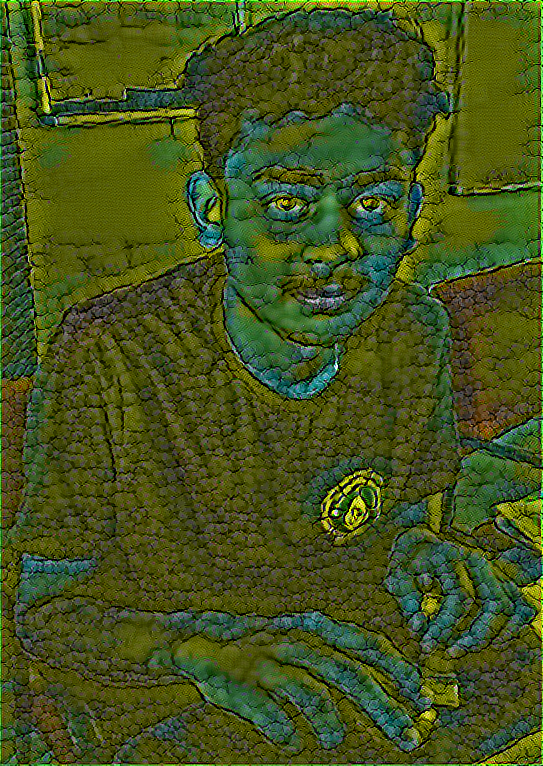

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [436]:
###############################
content_image_2 = cv2.cvtColor(content_image_2, cv2.COLOR_BGR2RGB)
#############################
# %%time
img = style_transfer(content_image=content_image_2,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=150,
                     step_size=10.0)

##############################################################################


# Notes

The computation power required will be higer and we may need GPU so, the inference can be very slow on a CPU!

In [0]:
# %cd content/mask-rcnn/
# %mkdir images
# %mkdir mask-rcnn-coco
# %mkdir output
# %mkdir videos

In [426]:
%matplotlib notebook
!python mask_rcnn.py --mask-rcnn mask-rcnn-coco --image images/pranav.jpg

python3: can't open file 'mask_rcnn.py': [Errno 2] No such file or directory
